In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, f1_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

## CLEANING THE DATA
df = pd.read_csv("C:/Users/User1/mlprojekti/songs.csv", encoding='ISO-8859-1') # Read the data

timbres = [elem for elem in df.columns if "timbre" in elem or "confidence" in elem] # Create a list of all column names that contain "timbre" or "confidence"

df.drop(timbres, axis=1, inplace = True) # Drop all columns names that contain "timbre" or "confidence"
df.drop(["pitch"], axis=1, inplace = True) # Drop column "pitch"


df1 = df.groupby("songID").filter(lambda x: (1 in x["Top10"].values) and (0 in x["Top10"].values))  # Check how many songs have at least 2 observations, one with Top10 == 1 and one with Top10 == 0
# len(df1)) == 0. 0 songs have been on the top 10 chart in some year but have not been on the chart in some other year.
# This means that it is enough to simply remove duplicate songs

df = df.drop_duplicates(subset=["songID"], keep="first") # Remove duplicate songs, keep the first instance
df.drop(["artistname", "artistID", "year", "songID"], axis=1, inplace = True) # Drop more columns that will not be useful

df["songnamelength"] = df["songtitle"].str.len() # Create new column that states the number of characters in the title of the song
df.drop(["songtitle"], axis=1, inplace = True) # Remove column for the song title as it is not needed anymore

df.dropna(axis=0, inplace=True) # Remove rows with NA values

# Create dummy variables (0 or 1) for all categories of categorical variables
df = pd.get_dummies(df, columns=["key", "timesignature"], drop_first=True)

#Print info of the data set
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7549 entries, 0 to 7573
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   loudness         7549 non-null   float64
 1   tempo            7549 non-null   float64
 2   energy           7549 non-null   float64
 3   Top10            7549 non-null   int64  
 4   songnamelength   7549 non-null   int64  
 5   key_1            7549 non-null   bool   
 6   key_2            7549 non-null   bool   
 7   key_3            7549 non-null   bool   
 8   key_4            7549 non-null   bool   
 9   key_5            7549 non-null   bool   
 10  key_6            7549 non-null   bool   
 11  key_7            7549 non-null   bool   
 12  key_8            7549 non-null   bool   
 13  key_9            7549 non-null   bool   
 14  key_10           7549 non-null   bool   
 15  key_11           7549 non-null   bool   
 16  timesignature_1  7549 non-null   bool   
 17  timesignature_3  75

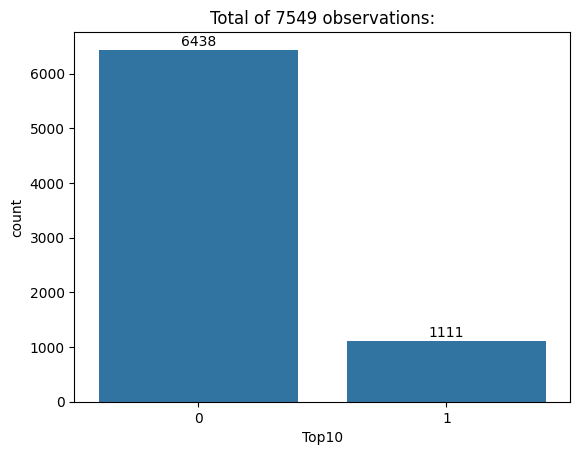

In [46]:
#PLOTTING
ax = sns.countplot(x="Top10", data=df)
plt.title(f"Total of {len(df)} observations:")
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x()+p.get_width()/2, p.get_height()), ha = 'center', va = 'baseline', 
                fontsize=10, color='black', xytext=(0, 3),
                textcoords='offset points')
plt.show()

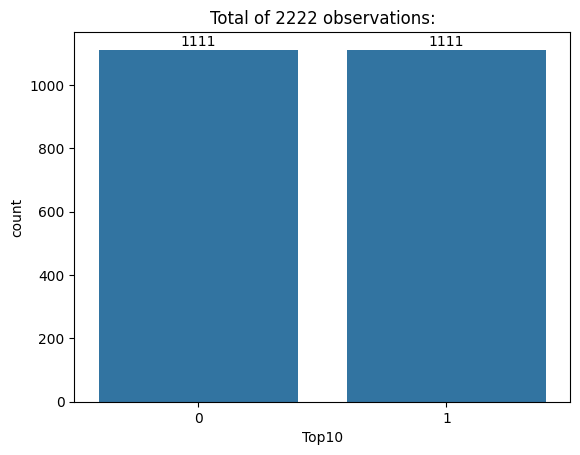

In [47]:

df_label_1 = df[df["Top10"] == 1]  # Separate classes
df_label_0 = df[df["Top10"] == 0]

# Undersample the minority class to match the n of majority class to avoid problems of imbalanced data sets.
df_label_0_new = resample(df_label_0, replace=False, n_samples=len(df_label_1), random_state=42)

df_balanced = pd.concat([df_label_1, df_label_0_new])

y = df_balanced["Top10"] # Label vector
X = df_balanced.drop(["Top10"], axis=1) # Feature vectors

#PLOTTING
ax = sns.countplot(x="Top10", data=df_balanced)
plt.title(f"Total of {len(df_balanced)} observations:")
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x()+p.get_width()/2, p.get_height()), ha = 'center', va = 'baseline', 
                fontsize=10, color='black', xytext=(0, 3),
                textcoords='offset points')
plt.show()


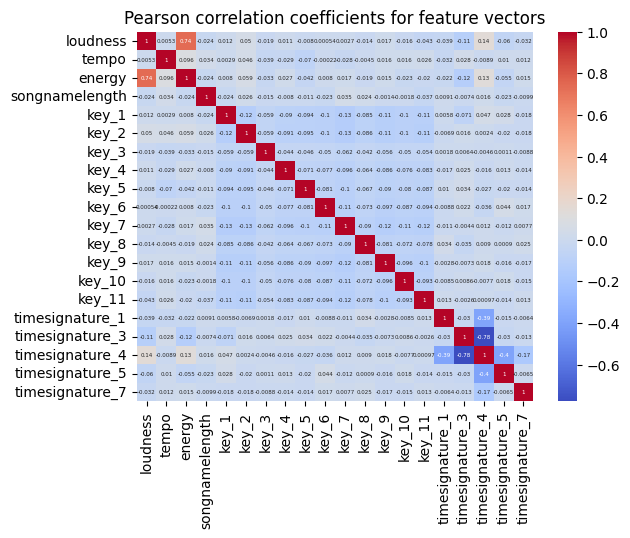

In [48]:
correlation_matrix = X.corr()
ax = plt.subplot()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 4})
ax.set_title("Pearson correlation coefficients for feature vectors")
plt.show()

In [49]:
#Energy and loudness correlate too much (between 0.7-0.9). One has to be removed. Check which predicts the label with higher accuracy.

for feature in df.columns:
    if feature == "energy" or feature == "loudness":
        X_train1, X_test1, y_train1, y_test1 = train_test_split(df[[feature]], df["Top10"], test_size=0.2, random_state=42)
        clf1 = LogisticRegression()
        clf1.fit(X_train1, y_train1)
        y_pred1 = clf1.predict(X_test1)
        accuracy1 = accuracy_score(y_test1, y_pred1)

        print(f"Accuracy of classification based on {feature}, Accuracy: {accuracy1}")


Accuracy of classification based on loudness, Accuracy: 0.8622516556291391
Accuracy of classification based on energy, Accuracy: 0.8629139072847682


In [50]:
# loudness seems to predict the label slightly worse so let's remove energy
X.drop(["loudness"], axis=1, inplace=True)

In [51]:
## LOGISTIC REGRESSOR

# Divide the data to training and testing data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = 42) # Split data into training and testing data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42)
param_grid = {'max_iter': [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}
clf = LogisticRegression(solver='liblinear') # Our dataset is quite small so liblinear should be a viable solver
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

best_clf = LogisticRegression(max_iter=best_params["max_iter"], solver='liblinear')
best_clf.fit(X_train, y_train) # Train the model

y_pred = best_clf.predict(X_val) # Predict y values based on testing feature data
y_train_pred = best_clf.predict(X_train) # Predict y values based on training feature data for training error

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)


Best parameters: {'max_iter': 50}


In [52]:
# RANDOM FOREST CLASSIFIER
y = df_balanced["Top10"] # Label vector
X = df_balanced.drop(["Top10"], axis=1) # Feature vectors

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = 42) # Split data into training and testing data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42)
param_grid = {'n_estimators': [100, 150, 200, 250],
              'criterion': ['gini', 'entropy', 'log_loss']
              }
rf = RandomForestClassifier(random_state=42) # Initialize random forest classifier
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
#print(f"Best parameters: {best_params}")

best_rf = RandomForestClassifier(n_estimators=best_params['n_estimators'], criterion=best_params["criterion"], max_depth=5, random_state=42)
best_rf.fit(X_train, y_train)

y_val_pred_rf = best_rf.predict(X_val)

y_train_pred_rf = best_rf.predict(X_train) # Predict y values based on training feature data for training error

#Testing metrics
accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
precision_rf = precision_score(y_val, y_val_pred_rf)
f1_rf = f1_score(y_val, y_val_pred_rf)
recall_rf = recall_score(y_val, y_val_pred_rf)

#Training metrics
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
train_precision_rf = precision_score(y_train, y_train_pred_rf)
train_f1_rf = f1_score(y_train, y_train_pred_rf)
train_recall_rf = recall_score(y_train, y_train_pred_rf)


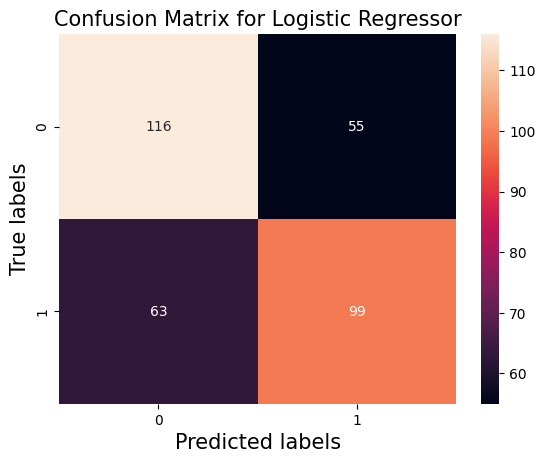

Validation metrics for logistic regressor:
Accuracy: 0.6456456456456456
Precision: 0.6428571428571429
F1-score: 0.6265822784810127
Recall score: 0.6111111111111112

Train metrics for logistic regressor:
Training accuracy: 0.5864951768488746
Training precision: 0.5862068965517241
Training f1-score: 0.5789129011132941
Training recall score: 0.5717981888745148








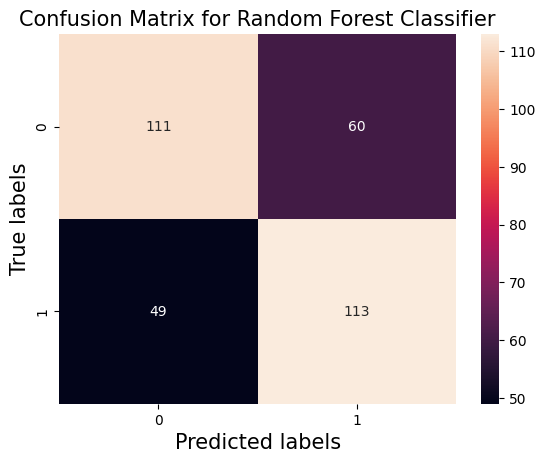

Validation metrics for random forest classifier:
Test accuracy: 0.6726726726726727
Precision: 0.653179190751445
F1-score: 0.6746268656716418
Recall score: 0.6975308641975309

Train metrics for random forest classifier:
Training accuracy: 0.6983922829581993
Training precision: 0.6974025974025974
Training f1 score: 0.696046662346079
Training recall score: 0.6946959896507116


In [53]:
conf_mat = confusion_matrix(y_val, y_pred)
ax= plt.subplot()

sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
ax.set_title('Confusion Matrix for Logistic Regressor',fontsize=15)
plt.show()

print("Validation metrics for logistic regressor:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1-score: {f1}")
print(f"Recall score: {recall}\n")


print("Train metrics for logistic regressor:")
print(f"Training accuracy: {train_accuracy}")
print(f"Training precision: {train_precision}")
print(f"Training f1-score: {train_f1}")
print(f"Training recall score: {train_recall}")

print("\n"*5)


conf_mat_rf = confusion_matrix(y_val, y_val_pred_rf)
ax= plt.subplot()

sns.heatmap(conf_mat_rf, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
ax.set_title('Confusion Matrix for Random Forest Classifier',fontsize=15)
plt.show()

print("Validation metrics for random forest classifier:")
print(f"Test accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"F1-score: {f1_rf}")
print(f"Recall score: {recall_rf}\n")

print("Train metrics for random forest classifier:")
print(f"Training accuracy: {train_accuracy_rf}")
print(f"Training precision: {train_precision_rf}")
print(f"Training f1 score: {train_f1_rf}")
print(f"Training recall score: {train_recall_rf}")
